# Bag-level Uncertainty Analysis

This notebook shows the bag-level uncertainty estimation (UE) behavior of MIREL models. 

In this experiment, each bag will be composed of both ID (in-distribution) and OOD (out-of-distribution) instances, where different mixing ratios are set. These bags will be taken into MIREL models for UE. 

## 1. Set global variables and load configurations

In [1]:
import os

ROOT_DIR = "/home/liup/repo/MIREL"
os.chdir(ROOT_DIR)
os.getcwd()

'/home/liup/repo/MIREL'

In [2]:
DATA_ORIGIN = 'mnist' 
OOD_DATA = 'fmnist'

PATH_CFG = 'config/mnist-bags/cfg_abmil_mirel.yaml'
RUN_SEED = 42
NUM_ID_BAGS = 1000 # MNIST ID bags
NUM_OOD_BAGS = 1000 # MNIST OOD bags
ALL_RATIO_OOD_INSTANCE = [i * 0.1 for i in range(11)]

### loading the configuration (`YAML` file) of MIREL models.

In [3]:
import yaml
import os.path as osp

config_path = osp.join(ROOT_DIR, PATH_CFG)
with open(config_path, "r") as setting:
    cfg = yaml.load(setting, Loader=yaml.FullLoader)
print(cfg)

{'task': 'clf', 'cuda_id': 0, 'seed': [42, 17, 26, 50, 82], 'wandb_dir': '/home/user/repo/MIREL', 'wandb_prj': 'MIREL-Experiment', 'save_path': './result/mirel-experiment/mnist-ABMIL-MIREL', 'save_prediction': True, 'save_ins_prediction': True, 'ins_pred_from': 'eins', 'eins_frozen_feat': False, 'dataset_origin': 'mnist', 'mnist_dataset_size': '500-100-1000', 'mnist_target_number': 9, 'mnist_mean_bag_length': 10, 'mnist_var_bag_length': 2, 'mnist_mean_pos_ratio': 0.5, 'mnist_id_labels': '0-1-2-3-4-5-6-7-8-9', 'mnist_ood_ratio': 1.0, 'mnist_ood_origin': ['fmnist', 'kmnist'], 'net_dims': '800-256-2', 'drop_rate': 0.0, 'backbone': 'ABMIL', 'use_feat_proj': 'mnist', 'init_wt': True, 'abmil_pooling': 'attention', 'edl_pred_head': 'default', 'edl_evidence_func': 'exp', 'edl_evidence_sum': True, 'edl_evidence_sum_separate': 'II', 'edl_evidence_sum_aggregate': 'diweight', 'loss_bce': True, 'loss_smoothing': 0.0, 'loss_bce_target_thresh': None, 'loss_edl': True, 'loss_edl_type': 'mse', 'loss_re

### Model setup

get the path of trained model

In [4]:
cfg[DATA_ORIGIN+'_ood_origin'] = OOD_DATA
cfg['seed'] = RUN_SEED

full_save_path = cfg['save_path'] + '-seed_{}'.format(cfg['seed']) + '-' + DATA_ORIGIN + '_ood_origin_' + OOD_DATA
ckpt_path = osp.join(full_save_path, 'train_model-best.pth')
if osp.exists(ckpt_path):
    print("Model will be loaded from", ckpt_path)
else:
    print("Model path is not found.")

Model will be loaded from ./result/mirel-experiment/mnist-ABMIL-MIREL-seed_42-mnist_ood_origin_fmnist/train_model-best.pth


load the MIREL model

In [5]:
import torch
from utils.func import seed_everything, parse_str_dims
from model.model_utils import load_model

torch.cuda.set_device(cfg['cuda_id'])
seed_everything(cfg['seed'])

dims = parse_str_dims(cfg['net_dims'])
model = load_model(
    cfg['task'], cfg['backbone'], dims, drop_rate=cfg['drop_rate'], use_feat_proj=cfg['use_feat_proj'], 
    edl_output=cfg['loss_edl'], edl_evidence_func=cfg['edl_evidence_func'], edl_pred_head=cfg['edl_pred_head'], 
    pooling=cfg['abmil_pooling'], ins_pred_from=cfg['ins_pred_from'], eins_frozen_feat=cfg['eins_frozen_feat']
).cuda()

net_ckpt = torch.load(ckpt_path)
model.load_state_dict(net_ckpt['model'])
model.eval()

[setup] seed: 42
[info] Initialized an instance enhancement layer: frozen_feat = False.
[info] Initialized an ABMIL model with EDL_head, and the pooling is attention.


ABMIL(
  (feat_proj): MNIST_Feat_Projecter(
    (feature_extractor_part1): Sequential(
      (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
      (1): Dropout2d(p=0, inplace=False)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
      (5): Dropout2d(p=0, inplace=False)
      (6): ReLU()
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (projecter): Sequential(
      (0): Linear(in_features=800, out_features=800, bias=True)
      (1): ReLU()
    )
  )
  (ins_layer): Scoring_Net(
    (attention): Sequential(
      (0): Linear(in_features=800, out_features=256, bias=True)
      (1): Tanh()
      (2): Linear(in_features=256, out_features=1, bias=True)
    )
  )
  (pred_head): Linear(in_features=800, out_features=2, bias=True)
  (ins_enhance_layer): Sequential(
    (0): Linear(in_features=800, out_features=256, bias=True)
 

### Dataset setup

load the test bags with a specific instance_ratio

In [6]:
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate

from dataset.PatchMNIST import MnistBags
from dataset.PatchCIFAR import CifarBags
from utils.func import seed_generator, seed_worker

def get_test_loader(ratio_ood_instance, num_id_bags=None, num_ood_bags=None):
    name_prefix = cfg['dataset_origin']
    cfg[name_prefix + '_ood_ratio'] = ratio_ood_instance
    print("[info] specified the ratio of OOD instances as {}".format(ratio_ood_instance))

    if cfg[name_prefix + '_id_labels'] is None or len(cfg[name_prefix + '_id_labels']) == 0:
        id_labels = None
    else:
        id_labels = parse_str_dims(cfg[name_prefix + '_id_labels'])
    
    if cfg[name_prefix + '_target_number'] is None:
        target_labels = None
    else:
        target_labels = parse_str_dims(cfg[name_prefix + '_target_number'])

    if name_prefix == 'mnist':
        BagDataset = MnistBags
    elif name_prefix == 'cifar10':
        BagDataset = CifarBags
    else:
        BagDataset = None

    size_train, size_val, size_test = parse_str_dims(cfg[name_prefix + '_dataset_size'])
    size_test = size_test if num_id_bags is None else num_id_bags
    assert NUM_ID_BAGS == size_test
    print("[info] num_id_bags={}, num_ood_bags={}.".format(size_test, num_ood_bags))
    
    dataset = BagDataset(
        target_number=target_labels,
        mean_bag_length=cfg[name_prefix + '_mean_bag_length'],
        var_bag_length=cfg[name_prefix + '_var_bag_length'],
        mean_pos_ratio=cfg[name_prefix + '_mean_pos_ratio'],
        num_bag=size_test,
        seed=96,
        data_name='test',
        label_allowed_in_train=id_labels,
        ood_origin=cfg[name_prefix + '_ood_origin'],
        ood_ins_ratio=cfg[name_prefix + '_ood_ratio'],
        ood_num_bag=num_ood_bags
    )
    
    loader = DataLoader(dataset, batch_size=1, 
        generator=seed_generator(cfg['seed']), num_workers=cfg['num_workers'], 
        shuffle=False, worker_init_fn=seed_worker, collate_fn=default_collate
    )
    
    return dataset, loader

### Model inference setup

In [7]:
from utils.func import has_no_ood_instance

def test_model(model, loader, loader_name=None, ratio_ood_instance=0, skip_first_n_samples=0):
    print("[info] test the model with the last {} bags in the test loader.".format(len(loader) - skip_first_n_samples))
    print("[info] current ratio_ood_instance is {}".format(ratio_ood_instance))
    model.eval()

    all_idx, all_pred, all_gt, all_gt_dist = [], [], [], []
    all_pred_ins, all_gt_ins = [], []
    skipped_ood_bags = 0
    for data_idx, data_x, data_y in loader:
        if data_idx.item() < skip_first_n_samples:
            continue
        
        # data_x = (feats, coords) | data_y = (label_slide, label_patch)
        X = data_x[0].cuda() 
        data_label = data_y[0] 
        ins_label  = data_y[1]
        
        # fiter those bags whose actual OOD instance ratio is not equal to the specified.
        if abs(((ins_label < -1e-5).sum().item() / ins_label.shape[-1]) - ratio_ood_instance) > 0.05:
            skipped_ood_bags += 1
            continue
        
        with torch.no_grad():
            logit_bag, ins_pred = model(X, ret_ins_res=True)
            if isinstance(ins_pred, tuple):
                ins_pred = ins_pred[1] # fetch the last one, i.e., enhanced instace predictions

        all_gt.append(data_label)
        all_pred.append(logit_bag.detach().cpu())
        all_idx.append(data_idx)
        all_gt_dist.append(has_no_ood_instance(ins_label, cfg)) # [1, N] -> [1, 1]
        
        all_gt_ins.append(ins_label.squeeze(0).tolist())
        all_pred_ins.append(ins_pred.squeeze(0).tolist())
        assert len(all_gt_ins[-1]) == len(all_pred_ins[-1]), "Please check the instance-level dimension."

    all_pred = torch.cat(all_pred, dim=0) # [B, num_cls]
    all_gt = torch.cat(all_gt, dim=0).squeeze() # [B, ]
    all_idx = torch.cat(all_idx, dim=0).squeeze() # [B, ]
    all_gt_dist = torch.cat(all_gt_dist, dim=0).squeeze() # [B, ]
    assert len(all_pred) <= NUM_OOD_BAGS

    cltor = dict()
    cltor['pred'] = {'y': all_gt, 'y_soft': all_gt_dist,  'y_hat': all_pred, 'idx': all_idx}
    # the first two elements are in python list style
    cltor['pred_ins'] = {'y': all_gt_ins, 'y_hat': all_pred_ins, 'idx': all_idx}
    print("[info] finished testing {} bags; {} bags are skipped".format(len(all_gt), skipped_ood_bags))

    return cltor

# 2. Put all together and run

In [8]:
all_preds = []
all_datasets = []
for i, r in enumerate(ALL_RATIO_OOD_INSTANCE):
    print(">>>>>>>>>> Start runing with ood_instance_ratio = {}".format(r))
    cur_test_set, cur_test_loader = get_test_loader(r, num_ood_bags=NUM_OOD_BAGS)
    cur_res = test_model(model, cur_test_loader, ratio_ood_instance=r, skip_first_n_samples=NUM_ID_BAGS)
    all_preds.append(cur_res)
    all_datasets.append(cur_test_set)
    print("<<<<<<<<<< End of running\n")

>>>>>>>>>> Start runing with ood_instance_ratio = 0.0
[info] specified the ratio of OOD instances as 0.0
[info] num_id_bags=1000, num_ood_bags=1000.
[info] there are 10000 images reserved in the dataset after keeping the numbers [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


/usr/local/lib64/python3.6/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib64/python3.6/site-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib64/python3.6/site-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


[warning] ood_ins_ratio is set to 0, so skipping the OOD replacement process and returing all ID bags.
[info] A total of 2000 bags is generated; the bags with OOD instances count 0.
[PatchMNIST] test: num_bag=1000, seed=96, data_name=test, target_number=[9], low_pos_ratio=0.0, ID labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ood_ins_ratio=0.0, ood_num_bag=1000.
[info] test the model with the last 1000 bags in the test loader.
[info] current ratio_ood_instance is 0.0


/usr/local/lib64/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[info] finished testing 1000 bags; 0 bags are skipped
<<<<<<<<<< End of running

>>>>>>>>>> Start runing with ood_instance_ratio = 0.1
[info] specified the ratio of OOD instances as 0.1
[info] num_id_bags=1000, num_ood_bags=1000.
[info] there are 10000 images reserved in the dataset after keeping the numbers [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


/usr/local/lib64/python3.6/site-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib64/python3.6/site-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


[info] there are 60000 OOD images from fmnist.
[info] A total of 2000 bags is generated; the bags with OOD instances count 1000.
[PatchMNIST] test: num_bag=1000, seed=96, data_name=test, target_number=[9], low_pos_ratio=0.0, ID labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ood_ins_ratio=0.1, ood_num_bag=1000.
[info] test the model with the last 1000 bags in the test loader.
[info] current ratio_ood_instance is 0.1
[info] finished testing 939 bags; 61 bags are skipped
<<<<<<<<<< End of running

>>>>>>>>>> Start runing with ood_instance_ratio = 0.2
[info] specified the ratio of OOD instances as 0.2
[info] num_id_bags=1000, num_ood_bags=1000.
[info] there are 10000 images reserved in the dataset after keeping the numbers [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[info] there are 60000 OOD images from fmnist.
[info] A total of 2000 bags is generated; the bags with OOD instances count 1000.
[PatchMNIST] test: num_bag=1000, seed=96, data_name=test, target_number=[9], low_pos_ratio=0.0, ID labels=[0, 1, 2, 3, 

## 3. Calculate bag-level confidence scores

In [9]:
import torch
import torch.nn.functional as F
import numpy as np

from eval.edl_metrics import compute_confidence_score
from eval.edl_metrics import compute_confidence_score_categorical

# Use `expected_entropy` for example
UNCERTAINTY_TYPES = ['expected_entropy']
# UNCERTAINTY_TYPES = ['expected_entropy', 'alpha0', 'differential_entropy', 'mutual_information'] 

def convert_to_tensor(data):
    if type(data) == torch.Tensor:
        data = data.squeeze().cpu() # [N, ]
    elif type(data) == np.ndarray:
        data = torch.from_numpy(np.squeeze(data)) # [N, ]
    return data

def bag_uncertainty_estimation(data_pred, edl_output=False):
    data = data_pred['pred'] # get bag-level predictions and labels
    Y, Y_soft, Y_hat = convert_to_tensor(data['y']), convert_to_tensor(data['y_soft']), convert_to_tensor(data['y_hat'])
    
    conf_scores = dict()
    for ut in UNCERTAINTY_TYPES:
        if edl_output:
            scores = compute_confidence_score(Y_hat, ut)
        else:
            assert len(Y_hat.shape) == 2
            Y_hat = F.softmax(Y_hat, dim=1)
            scores = compute_confidence_score_categorical(Y_hat, ut)
        conf_scores[ut] = scores
    return conf_scores

In [10]:
all_conf_scores = []
for i, r in enumerate(ALL_RATIO_OOD_INSTANCE):
    print(">>>>>>>>>> Start calculating confidence scores with ood_instance_ratio = {}".format(round(r,2)))
    cur_pred = all_preds[i]
    cur_conf_scores = bag_uncertainty_estimation(cur_pred, edl_output=cfg['loss_edl'])
    all_conf_scores.append(cur_conf_scores)

>>>>>>>>>> Start calculating confidence scores with ood_instance_ratio = 0.0
>>>>>>>>>> Start calculating confidence scores with ood_instance_ratio = 0.1
>>>>>>>>>> Start calculating confidence scores with ood_instance_ratio = 0.2
>>>>>>>>>> Start calculating confidence scores with ood_instance_ratio = 0.3
>>>>>>>>>> Start calculating confidence scores with ood_instance_ratio = 0.4
>>>>>>>>>> Start calculating confidence scores with ood_instance_ratio = 0.5
>>>>>>>>>> Start calculating confidence scores with ood_instance_ratio = 0.6
>>>>>>>>>> Start calculating confidence scores with ood_instance_ratio = 0.7
>>>>>>>>>> Start calculating confidence scores with ood_instance_ratio = 0.8
>>>>>>>>>> Start calculating confidence scores with ood_instance_ratio = 0.9
>>>>>>>>>> Start calculating confidence scores with ood_instance_ratio = 1.0


## 4. Visualization of bag samples and confidence score distribution

In [11]:
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

mpl.rc('pdf', fonttype=42)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

In [12]:
def visualize_conf_scores_by_density(
        xs, scores, title, cumulative=False, norm=False, log_scale=False, 
        bw_adjust=1, cmp_name='viridis', save_path=None
    ):
    sns.set_theme(style="whitegrid")
    figure, axes = plt.subplots(figsize=(4.5,4))
    # get colors
    cmp = plt.cm.get_cmap(cmp_name)
    x_colors = [cmp(int((1.0 - x) * cmp.N)) for x in xs]
    
    if norm:
        y_min = min([_.min() for _ in scores])
        y_max = max([_.max() for _ in scores])
        norm_scores = []
        for i in range(len(scores)):
            nyi = (scores[i] - y_min) / (y_max - y_min)
            norm_scores.append(nyi)
        for i in range(len(norm_scores)):
            i_label = "{:.1f}".format(xs[i])
            sns.kdeplot(norm_scores[i], ax=axes, cumulative=cumulative, legend=True, log_scale=log_scale, 
                        label=i_label, color=x_colors[i], lw=2)
    else:
        for i in range(len(scores)):
            i_label = "{:.1f}".format(xs[i])
            sns.kdeplot(scores[i], ax=axes, cumulative=cumulative, legend=True, log_scale=log_scale, 
                        label=i_label, color=x_colors[i], lw=2)
    
    # title = " ".join(title.split("_"))
    axes.set_xlabel(f"Bag-level predictive confidence")
    axes.set_ylabel("Cumulative density")
    if norm:
        axes.set_xlim([0, 1])
    axes.set_ylim([0, 1])
    plt.legend(title="OOD ratio")
    axes.spines['bottom'].set_linewidth(0.8)
    axes.spines['left'].set_linewidth(0.8)
    axes.spines['right'].set_linewidth(0.8)
    axes.spines['top'].set_linewidth(0.8)
    axes.spines['bottom'].set_color('black')
    axes.spines['left'].set_color('black')
    axes.spines['right'].set_color('black')
    axes.spines['top'].set_color('black')
    plt.tick_params(reset=True, direction='out', length=3, width=1, colors='black', top=False,right=False)
    if save_path is not None:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    plt.show()
    
def visualize_bag_sample(bag_sample, label=None):
    n_ins = bag_sample.shape[0]
    new_bag_sample = np.ones((28, 28*n_ins))
    for i in range(n_ins):
        new_bag_sample[:, (i*28):(i*28+28)] = bag_sample[i].numpy()
    
    sns.set_theme(style="white")
    figure, axes = plt.subplots(figsize=(n_ins * 0.8, 6))
    axes.set_title(label)
    axes.imshow(new_bag_sample, cmap='gray')

### Bag sample visualization under different `ratio_ood_instance`

- ID instance: MNIST image
- OOD instance: FMNIST image

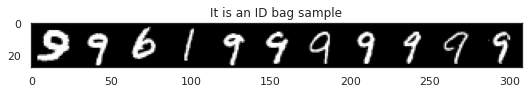

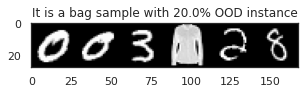

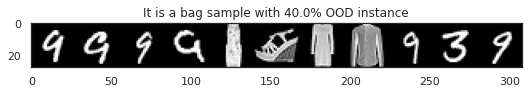

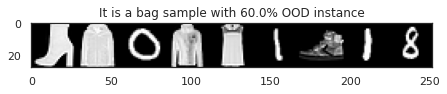

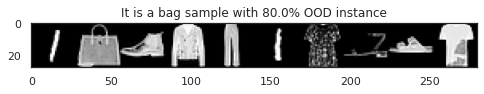

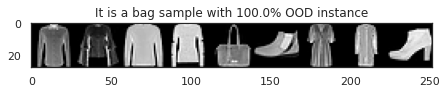

In [13]:
selected_idx_of_ratio = [0, 2, 4, 6, 8, 10]
for i in selected_idx_of_ratio:
    test_data = all_datasets[i]
    # starting from NUM_ID_BAGS as the first NUM_ID_BAGS are ID bags
    ood_ratio = round(ALL_RATIO_OOD_INSTANCE[i], 2)
    cur_ood_ratio = -1
    data_idx = -1
    while abs(cur_ood_ratio - ood_ratio) > 0.05:
        idx_OOD_bag = NUM_ID_BAGS + np.random.randint(NUM_OOD_BAGS)
        data_idx, data_x, data_y = test_data[idx_OOD_bag]
        # calculate current OOD instance ratio in this bag
        data_label, ins_label = data_y[0], data_y[1]
        cur_ood_ratio = (ins_label < -1e-5).sum().item() / ins_label.shape[-1]
    
    cur_bag_sample = test_data.test_bags_list[data_idx]
    if abs(ood_ratio) < 1e-5:
        label = "It is an ID bag sample"
    else:
        label = f"It is a bag sample with {ood_ratio*100}% OOD instance"
    visualize_bag_sample(cur_bag_sample, label=label)

### Bag-level confidence score distribution under different `ratio_ood_instance` 

When the OOD instance ratio is **larger**, the confidence score output by the model should be **smaller**, i.e., higher predictive uncertainty. 

The figure below shows that our MIREL model could capture bag-level uncertainty. Vanilla ABMIL cannot do this; refer to our paper for the comparative results.

Confidence measured by expected_entropy


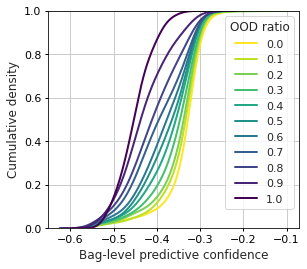

In [14]:
for i, unc in enumerate(UNCERTAINTY_TYPES):
    cur_conf_scores = [data[unc] for data in all_conf_scores]
    if cur_conf_scores[0] is None:
        print(f"No scores, so skipping the {unc}")
        continue
    
    print("Confidence measured by", unc)
    visualize_conf_scores_by_density(
        ALL_RATIO_OOD_INSTANCE, cur_conf_scores, unc, norm=False, cumulative=True
    )